In [1]:
import gensim, pyLDAvis, pickle, zipfile, logging, pyLDAvis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyLDAvis import gensim as gs
from ast import literal_eval
from os.path import exists

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Load the model, corpus, dictionary and data

In [2]:
model = gensim.models.LdaModel.load('models/model_rs1024k36')
with open('models/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)
dictionary = gensim.corpora.dictionary.Dictionary.load('models/dictionary')

if not exists('data/data_for_interpretation.csv'):
    print('Unzipping data.zip')
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

df = pd.read_csv('data/data_for_interpretation.csv', usecols=["scopusId", "title", "keywords", "abstract", "data", "data_preprocessed", "modularity_class"])  
df['data_preprocessed'] = df['data_preprocessed'].apply(literal_eval)

2021-08-09 22:11:01,218 : INFO : loading LdaModel object from models/model_rs1024k36
2021-08-09 22:11:01,223 : INFO : loading expElogbeta from models/model_rs1024k36.expElogbeta.npy with mmap=None
2021-08-09 22:11:01,227 : INFO : setting ignored attribute id2word to None
2021-08-09 22:11:01,228 : INFO : setting ignored attribute dispatcher to None
2021-08-09 22:11:01,230 : INFO : setting ignored attribute state to None
2021-08-09 22:11:01,231 : INFO : loaded models/model_rs1024k36
2021-08-09 22:11:01,232 : INFO : loading LdaState object from models/model_rs1024k36.state
2021-08-09 22:11:01,241 : INFO : loaded models/model_rs1024k36.state
2021-08-09 22:11:03,553 : INFO : loading Dictionary object from models/dictionary
2021-08-09 22:11:03,559 : INFO : loaded models/dictionary


Show the topics

In [3]:
topics = model.show_topics(formatted=False, num_topics=36)
topics

[(0,
  [('privacy', 0.03103014),
   ('trust', 0.028862176),
   ('consumer', 0.02704857),
   ('online', 0.022468684),
   ('study', 0.01854209),
   ('service', 0.017270174),
   ('customer', 0.015936768),
   ('factor', 0.015766488),
   ('model', 0.015484132),
   ('concern', 0.014222356)]),
 (1,
  [('mobile', 0.11766846),
   ('device', 0.052952792),
   ('application', 0.037560917),
   ('user', 0.034242783),
   ('apps', 0.024340007),
   ('android', 0.021536397),
   ('phone', 0.020028356),
   ('privacy', 0.018838057),
   ('app', 0.015935639),
   ('security', 0.015744444)]),
 (2,
  [('feature', 0.028902177),
   ('method', 0.021864047),
   ('quantum', 0.020099802),
   ('based', 0.016544916),
   ('face', 0.01588667),
   ('privacy', 0.015055142),
   ('using', 0.013880183),
   ('homomorphic', 0.013144591),
   ('vector', 0.012440906),
   ('encryption', 0.012071921)]),
 (3,
  [('network', 0.09620699),
   ('wireless', 0.047255374),
   ('node', 0.043838922),
   ('sensor', 0.042671338),
   ('privacy',

Generate and show a pyLDAvis visualisation for easy exploration (topic numbers are +1)

In [4]:
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, 'visualisation.html')
pyLDAvis.display(vis)

2021-08-09 22:13:07,379 : INFO : NumExpr defaulting to 8 threads.


Loop through all the documents to infer document-topics distribition

In [5]:
def inf_dist(text):
          
    bow = model.id2word.doc2bow(text)
    topics = model.get_document_topics(bow, per_word_topics=False)

    dic_topics = {}
    for t in topics:
        dic_topics[t[0]] = float(t[1])

    return dic_topics
      
df["document_topic_distribution"] = df["data_preprocessed"].map(inf_dist)

Loop trought all documents and classify with a main topic

In [6]:
def main_topic(text):
    
    highest_key = -1
    highest_value = -1
    
    for k in text.keys():
        if text[k] > highest_value:
            highest_key = k
            highest_value = text[k]
    
    return highest_key

df["main_topic"] = df["document_topic_distribution"].map(main_topic)

Add a column with the proportion of the main topic

In [7]:
def main_topic_value(text):
    
    highest_key = -1
    highest_value = -1
    
    for k in text.keys():
        if text[k] > highest_value:
            highest_key = k
            highest_value = text[k]
    
    return highest_value

df["main_topic_value"] = df["document_topic_distribution"].map(main_topic_value)

Make a dataframe with individual columns for each topic and community (modularity class) for easy correlation computation

In [8]:
topic_dicts = [{} for topic in range(36)]

# make dict of values for eacht topic
for i, topic_dict in enumerate(topic_dicts):
    
    for j, topic_distribution in enumerate(df['document_topic_distribution']):
        try:
            value = topic_distribution[i]
        except:
            value = 0
        
        topic_dicts[i][j] = value 

topic_per_paper = pd.DataFrame(topic_dicts).transpose()
topic_per_paper.columns = ['Topic ' + str(i) for i in range(36)]

Manually specify topic names

In [9]:
topic_names = {'Topic {}'.format(i): topic for i, topic in enumerate(['consumer privacy', 'smartphones', 'quantum encryption', 'networking', 'smart grid', 'image processing', 'data mining', 'legal', 'security operations', 'big data', 'internet of things', 'multi-party computing', 'privacy-preserving algorithms', 'social media', 'digital services', 'RFID', 'biometrics', 'healthcare (patient privacy)', 'recommender systems (healthcare)', 'physical monitoring', 'location data', 'access control', 'blockchain', 'cloud computing', 'encryption', 'data privacy', 'systems design', 'ethics', 'vehicular ad hoc networks', 'social networks', 'patient data', 'statistics', 'empirical studies', 'encryption schemes', 'web applications', 'cloud storage'])}
topic_names

{'Topic 0': 'consumer privacy',
 'Topic 1': 'smartphones',
 'Topic 2': 'quantum encryption',
 'Topic 3': 'networking',
 'Topic 4': 'smart grid',
 'Topic 5': 'image processing',
 'Topic 6': 'data mining',
 'Topic 7': 'legal',
 'Topic 8': 'security operations',
 'Topic 9': 'big data',
 'Topic 10': 'internet of things',
 'Topic 11': 'multi-party computing',
 'Topic 12': 'privacy-preserving algorithms',
 'Topic 13': 'social media',
 'Topic 14': 'digital services',
 'Topic 15': 'RFID',
 'Topic 16': 'biometrics',
 'Topic 17': 'healthcare (patient privacy)',
 'Topic 18': 'recommender systems (healthcare)',
 'Topic 19': 'physical monitoring',
 'Topic 20': 'location data',
 'Topic 21': 'access control',
 'Topic 22': 'blockchain',
 'Topic 23': 'cloud computing',
 'Topic 24': 'encryption',
 'Topic 25': 'data privacy',
 'Topic 26': 'systems design',
 'Topic 27': 'ethics',
 'Topic 28': 'vehicular ad hoc networks',
 'Topic 29': 'social networks',
 'Topic 30': 'patient data',
 'Topic 31': 'statistics

Manually specify community names

In [11]:
communities = [403, 607, 1005, 1259, 1053, 605, 631, 510, 782, 674, 855, 1239, 681, 854, 922, 1147, 616, 1263, 946, 284]
names = ['individual privacy and law', 'cloud computing', 'e-health and medical data', 'genetic data', 'data mining', 'location data', 'anonymity metrics', 'internet of things', 'differential privacy', 'electronic voting', 'networking', 'cybersecurity', 'mobile devices and apps', 'system architec ture and design', 'vehicular ad hoc networks', 'RFID', 'social media', 'hysical privacy (various)', 'biometrics', 'smart grid']
len(names)
community_names = dict(zip(communities, names))
community_names

{403: 'individual privacy and law',
 607: 'cloud computing',
 1005: 'e-health and medical data',
 1259: 'genetic data',
 1053: 'data mining',
 605: 'location data',
 631: 'anonymity metrics',
 510: 'internet of things',
 782: 'differential privacy',
 674: 'electronic voting',
 855: 'networking',
 1239: 'cybersecurity',
 681: 'mobile devices and apps',
 854: 'system architec ture and design',
 922: 'vehicular ad hoc networks',
 1147: 'RFID',
 616: 'social media',
 1263: 'hysical privacy (various)',
 946: 'biometrics',
 284: 'smart grid'}

Show a heatmap of topic occurence correlation

In [12]:
topic_correlations = topic_per_paper.corr()

f, ax = plt.subplots(figsize=(22, 16), dpi = 480)
mask = np.triu(np.ones_like(topic_correlations, dtype=bool))
triangle = sns.heatmap(topic_correlations, cmap=sns.color_palette("vlag_r", as_cmap=True), center = 0, annot=True, mask = mask, fmt='.2f', xticklabels=topic_names.values(), yticklabels=topic_names.values())
triangle.get_figure().savefig('triangle.png', bbox_inches='tight')
triangle

<AxesSubplot:>

Compute the averate presence of each topic for each community (modularity class)

In [13]:
topic_per_paper_with_community = pd.concat([df['modularity_class'], topic_per_paper], axis=1)
topical_distr_per_community = {}

for key in communities:        
    
    entries = topic_per_paper_with_community[topic_per_paper_with_community['modularity_class'] == int(key)]        
                
    averages = {}
    
    for topic in ['Topic ' + str(i) for i in range(36)]:
        averages[topic] = entries[topic].mean()

    topical_distr_per_community['Modularity class ' + str(key)] = averages
    
topical_distr_per_community_df = pd.DataFrame(topical_distr_per_community).transpose()

Create a heatmap to visualise average occurance of a topic within each community

<AxesSubplot:>

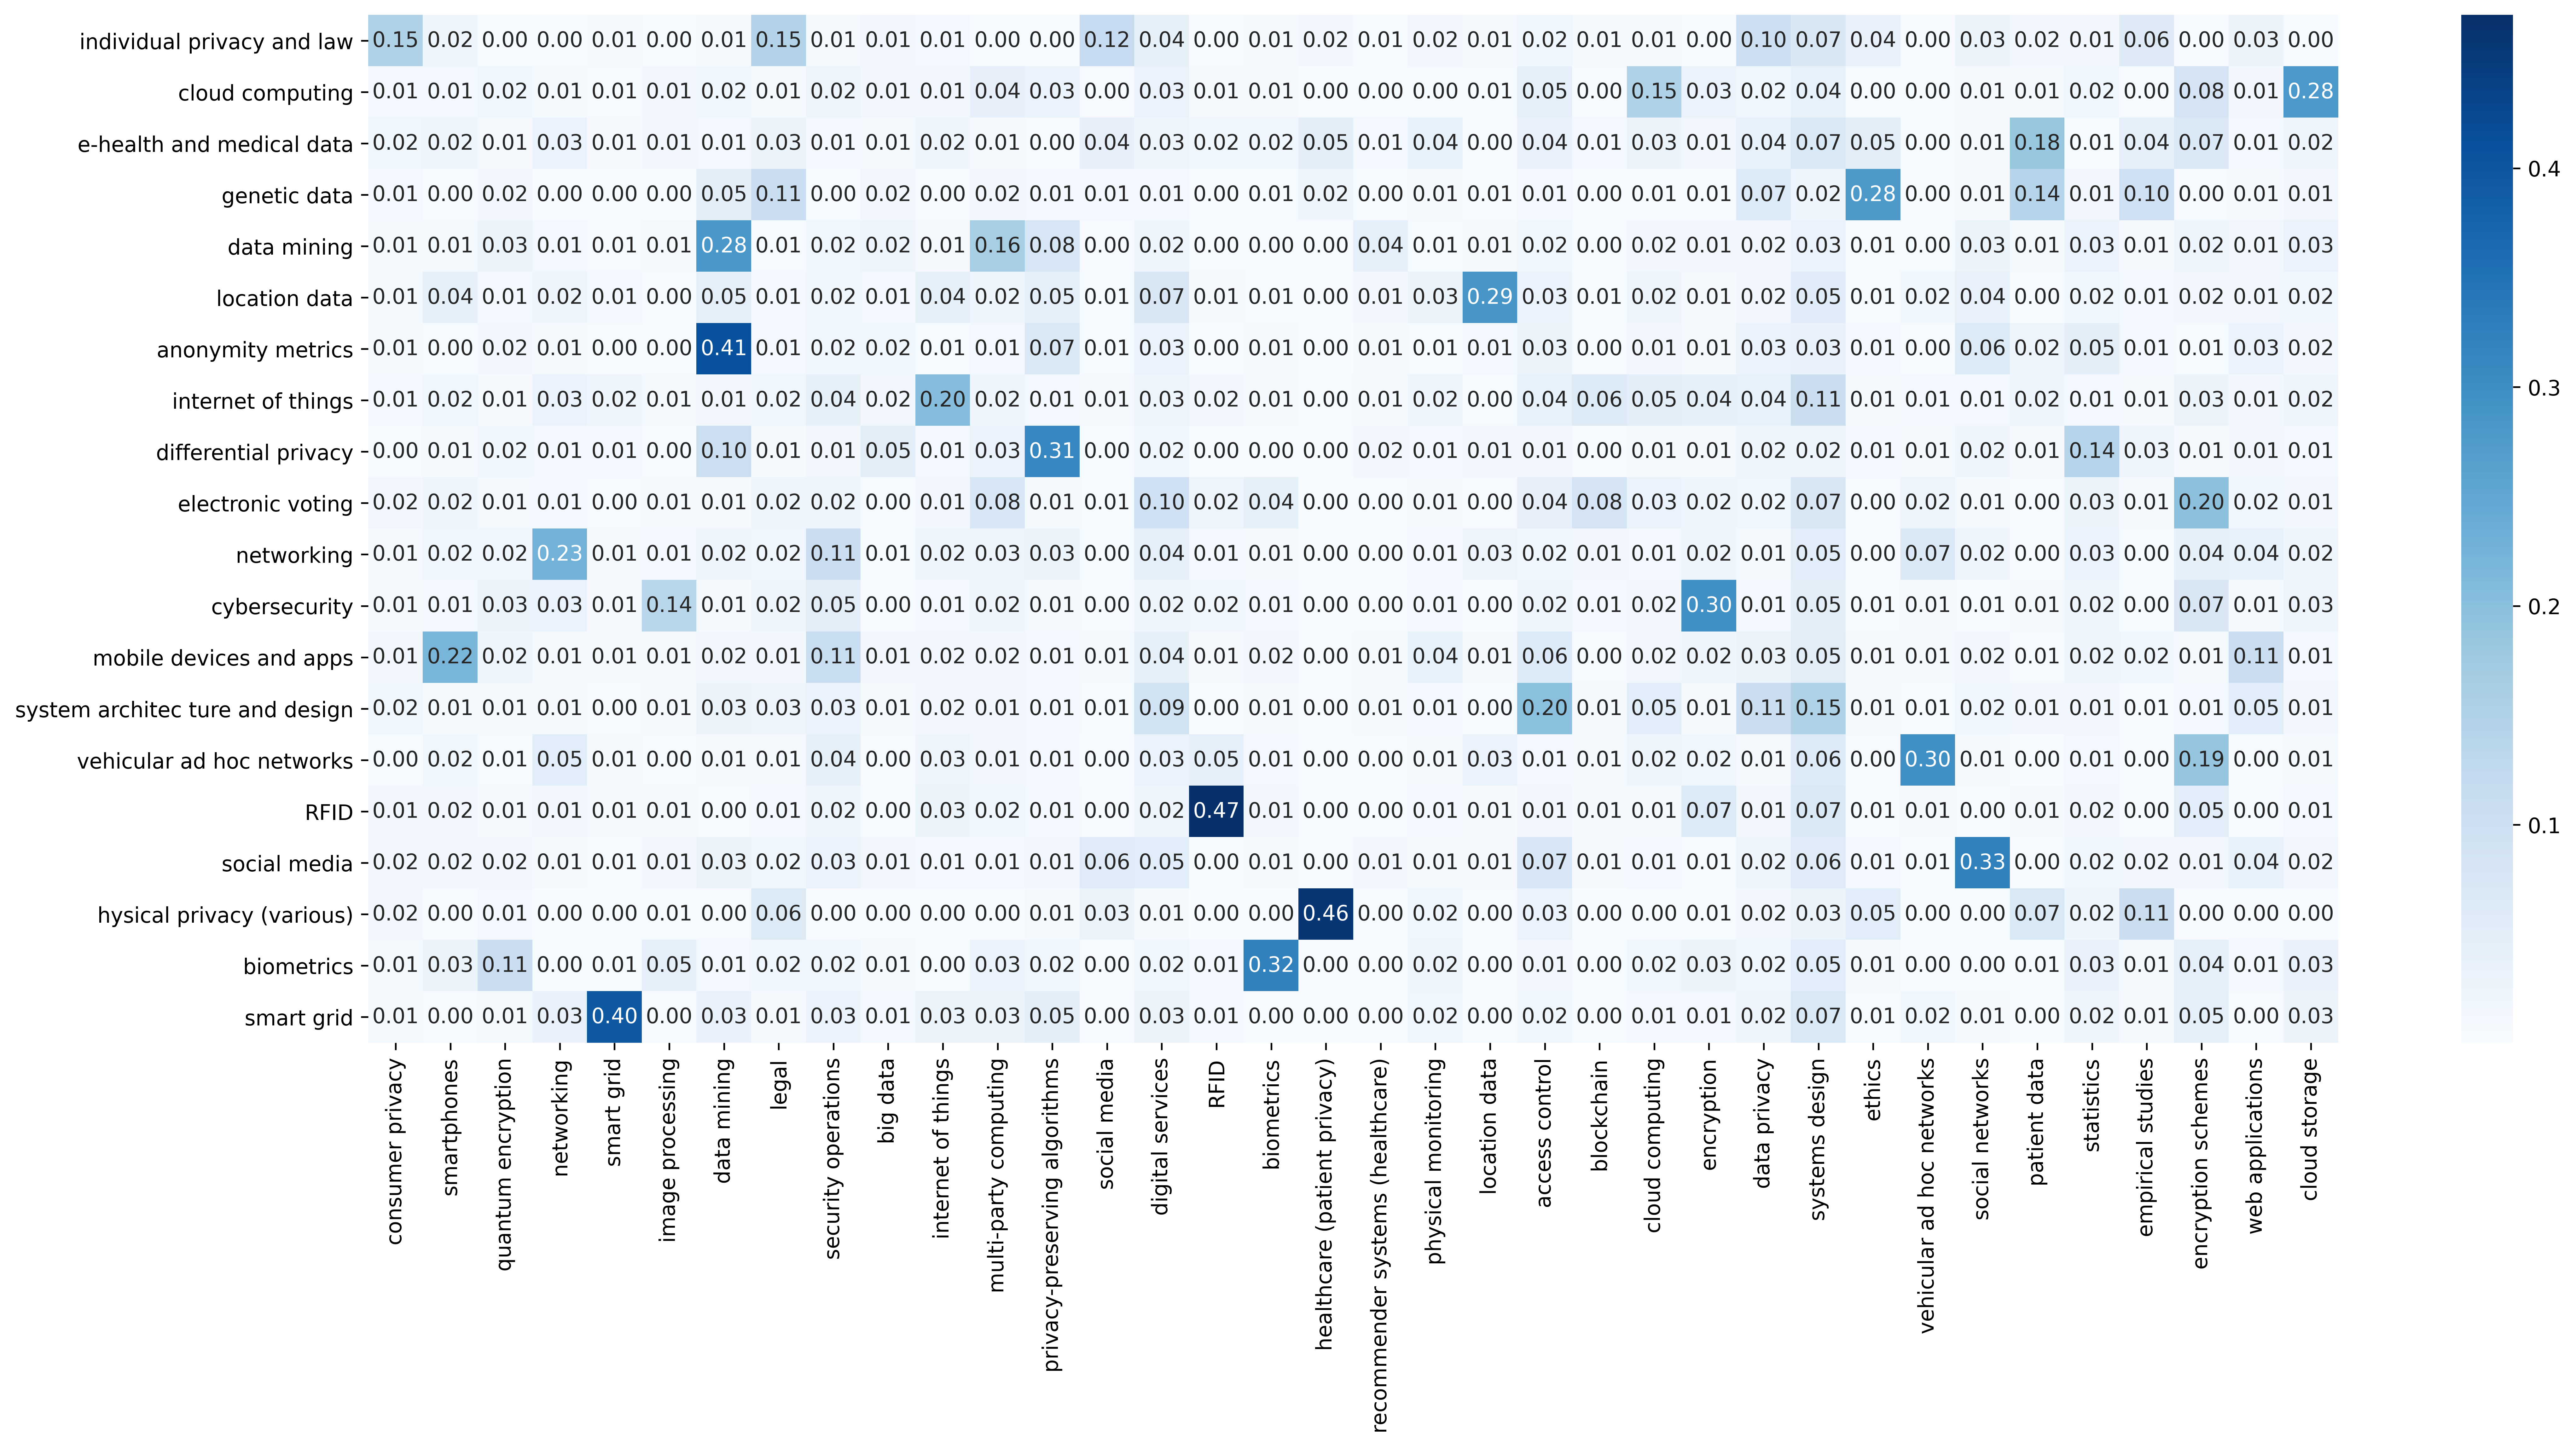

In [14]:
f, ax = plt.subplots(figsize=(21, 9), dpi = 480)
square = sns.heatmap(topical_distr_per_community_df, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, fmt='.2f', xticklabels=topic_names.values(), yticklabels=community_names.values())
square.get_figure().savefig('square.png', bbox_inches='tight')
square